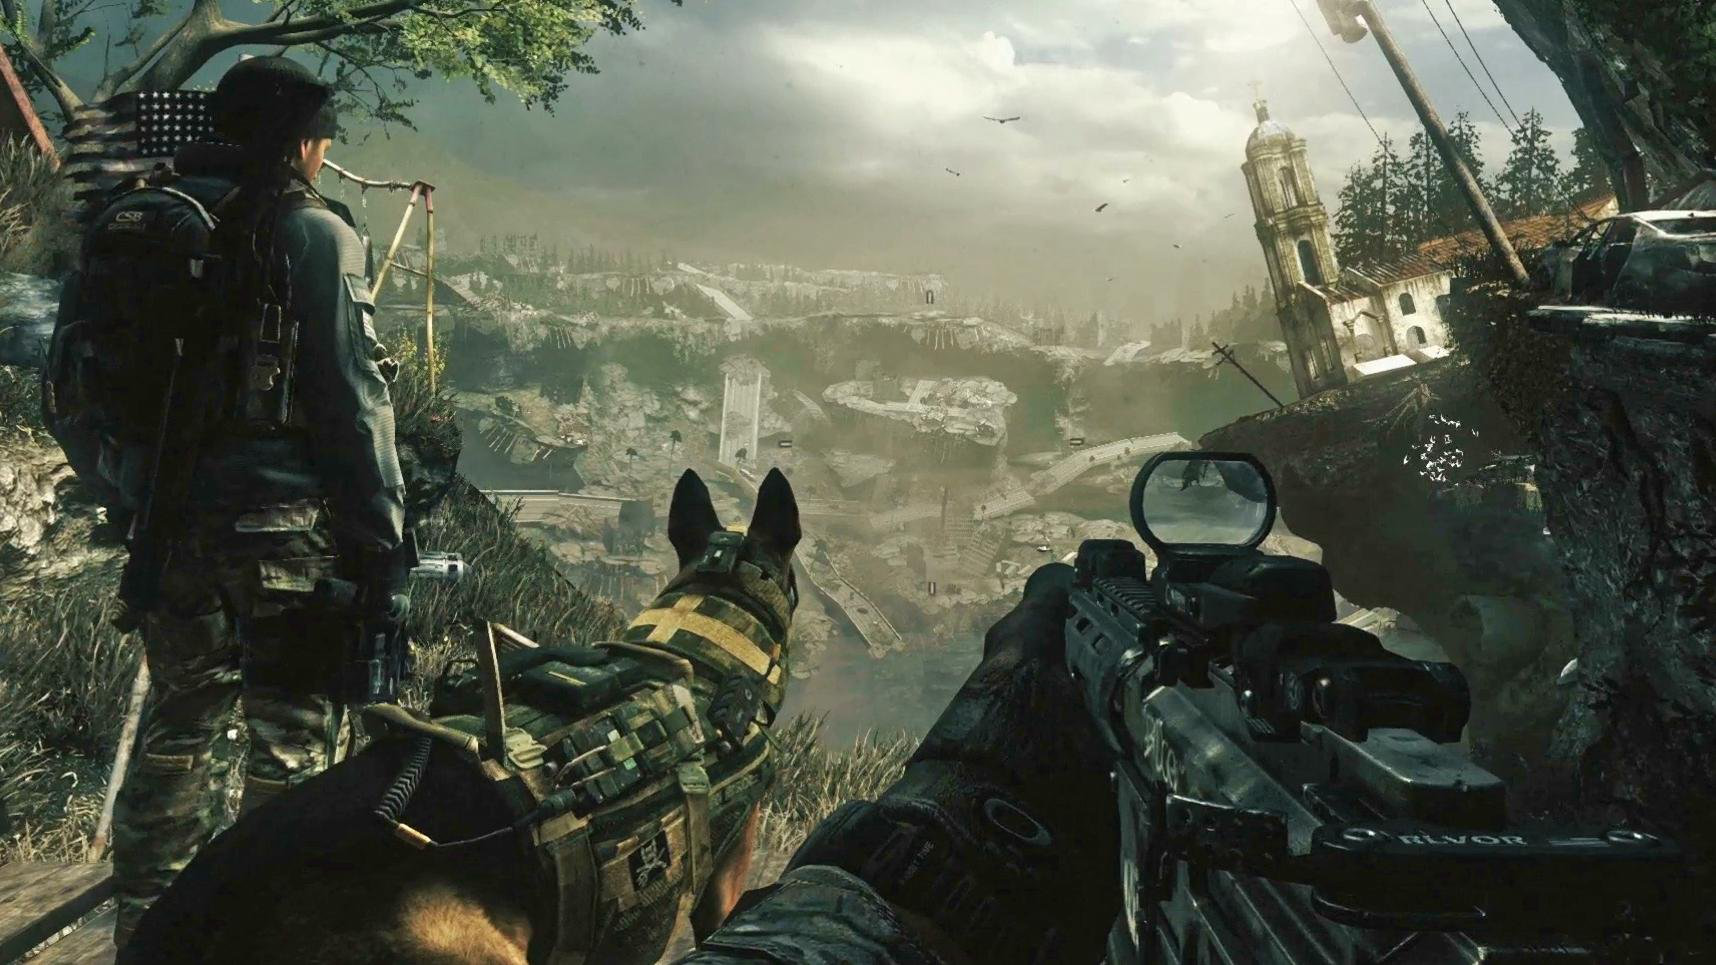

In [2]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

open_image('/content/call-of-duty-ghosts.jpeg')

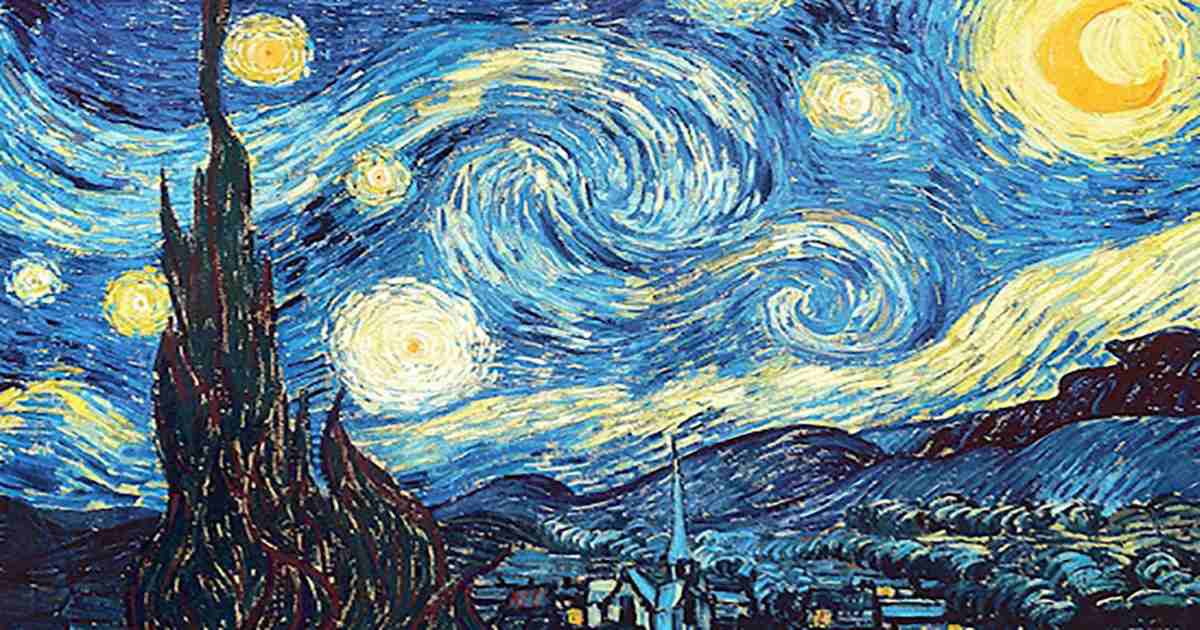

In [3]:
open_image('/content/starrynight.jpeg')

In [4]:
import torchvision.models as models
from torchvision.transforms import transforms as T
import torch.optim as optim
import torch.nn as nn
import torch
from torchvision.utils import save_image

In [5]:
model=models.vgg19(pretrained=True).features

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [6]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
#need 5 conv blocks

class VGG(nn.Module):
  def __init__(self,pretrained=True):
    super(VGG,self).__init__()
    self.chosen_features=['0','5','10','19','28']
    self.model=models.vgg19(pretrained=pretrained).features[:29]

  def forward(self,x):
    features=[]
    for layer_num,layer in enumerate(self.model):
      x=layer(x)
      if str(layer_num) in self.chosen_features:
        features.append(x)
    return features
    

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [9]:
device=get_default_device()
device

device(type='cuda')

In [10]:
model=to_device(model,device)

In [11]:
image_size=256
loader=T.Compose([
    T.Resize((256,256)),
    T.ToTensor()
])

In [12]:
def load_image(path):
  image=Image.open(path)
  image=loader(image).unsqueeze(0)
  return image.to(device)

In [13]:
original_image=load_image('/content/dancing.jpeg')
style_image=load_image('/content/starrynight.jpeg')

In [14]:
generated=original_image.clone().requires_grad_(True)

In [15]:
epochs=6000
lr=0.001
alpha=1
beta=0.01
optimizer=optim.Adam([generated],lr=lr)


In [16]:
for epoch in range(epochs):
  generated_features=model(generated)
  original_img_features=model(original_image)
  style_features=model(style_image)
  style_loss=content_loss=0

  for generated_feature,original_feature,style_feature in zip(
      generated_features,original_img_features,style_features
  ):
      
    batch_size,channel,height,width=generated_features.shape
    content_loss+=torch.mean((generated_feature-original_feature)**2)

    G=generated_feature.view(channel,height*width).mm(
      generated_feature.view(channel,height*width).t()
    )
    A=style_feature.view(channel,height*width).mm(
      style_feature.view(channel,height*width).t()
    )
    style_loss+=torch.mean((G-A)**2)
  total_loss=alpha*content_loss+beta*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if epoch%200==0:
    print(total_loss)
    save_image(generated,'generated.png')


tensor(0.3877, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1603, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1549, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1528, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1516, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1507, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1501, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1497, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1489, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1486, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1483, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1480, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1471, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1466, device='cuda:0', grad_fn=<AddBack

In [17]:
generated_feature.shape

torch.Size([512, 8, 8])

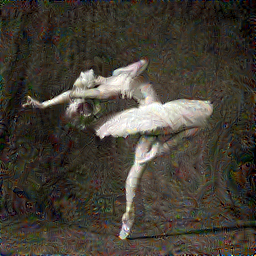

In [18]:
open_image("/content/generated.png")